In [1]:
!pip install Keras-Preprocessing
!pip install keras-lr-finder
!pip install kaggle

In [3]:
!mkdir kaggle
import os
import json
api_token = {"username":"dereklai7","key":"052aeb88d00b383c9144da59933f88ce"}
with open('kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

mkdir: cannot create directory ‘kaggle’: File exists


In [4]:
!chmod 600 /content/kaggle/kaggle.json

chmod: cannot access '/content/kaggle/kaggle.json': No such file or directory


In [5]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000  -p .

100%|█████████████████████████████████████▉| 5.20G/5.20G [17:15<00:00, 5.89MB/s]
100%|██████████████████████████████████████| 5.20G/5.20G [17:15<00:00, 5.39MB/s]


In [19]:
!unzip -l skin-cancer-mnist-ham10000.zip *.csv

Archive:  skin-cancer-mnist-ham10000.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   563277  2019-10-06 16:59   HAM10000_metadata.csv
 30807979  2019-10-06 17:03   hmnist_28_28_L.csv
 91820383  2019-10-06 17:03   hmnist_28_28_RGB.csv
  2537778  2019-10-06 17:03   hmnist_8_8_L.csv
  7524968  2019-10-06 17:03   hmnist_8_8_RGB.csv
---------                     -------
133254385                     5 files


In [20]:
!unzip  skin-cancer-mnist-ham10000.zip HAM10000_metadata.csv

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: HAM10000_metadata.csv   


In [9]:
import os
import urllib.request
import zipfile


urls = {
    "train" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip",
    "train_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip",
    "validation" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip",
    "validation_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip",
    "test" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip",
    "test_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip"
    #"train_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip",
    #"train_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip",
    #"validation_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip",
    #"validation_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip",

}

def download_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        if os.path.exists(filename):
            print(f"already exists file {filename}")
        else:
            print(f"downloading {filename} from {url} ...")
            urllib.request.urlretrieve(url, filename)
    print(f"done downloading all")

def unzip_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        print(filename)
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            print(f"unzipping {filename} to folder")
            zip_ref.extractall(f"{name}")

download_all()
unzip_all()

downloading train.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip ...
downloading train_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip ...
downloading validation.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip ...
downloading validation_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip ...
downloading test.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip ...
downloading test_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip ...
done downloading all
train.zip
unzipping train.zip to folder
train_ground_truth.zip
unzipping train_ground_truth.zip to folder
validation.zip
unzipping validation.zip to folder
validation_ground_truth.zip
unzipping validation_ground_truth.zip to fol

Model code starts here

In [4]:
import keras as k
import tensorflow as tf
import cv2
from keras import layers
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import numpy as np

import sklearn.metrics
import os

2024-02-07 19:31:40.358411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 19:31:40.358467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 19:31:40.420095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 19:31:40.553160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 19:31:41.645737: W tensorflow/compiler/tf2

Create Classification Model

In [31]:
def get_classification_functional(input_shape):
  inputs = layers.Input(shape=input_shape)
  densenet121 = k.applications.DenseNet121(include_top=False, input_tensor=inputs)#weights='imagenet' #Can use VGG19 instead
  x = densenet121(inputs, training=True) #change back
  #add optional classification layers here (if you add some youll have to change the layer indices in following functions)
  #x = layers.Conv2D(64, 3, input_shape=(112,112,3), activation='relu', padding="same")(x)
  #x = layers.Conv2D(64, 3, input_shape=(112,112,3), activation='relu', padding="same")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  # output layer, change activation function based on task:
  # multiclass classification = softmax
  # ...
  x = layers.Flatten()(x)
  x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(2048, activation='relu')(x)
  x = layers.Activation(activation="relu")(x)
  x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(7, activation="softmax")(x)
  classification_model_1 = k.Model(inputs=inputs, outputs=outputs, name="classification1")
  return classification_model_1

def get_classification_sequential(input_shape, stage, model=None):
  # inputs = layers.Input(shape=input_shape)
  if stage == 0:
    x = k.applications.DenseNet121(include_top=False, input_shape=input_shape)
    x.layers.pop(0)
    x.layers.pop(0)
  
  pretrained_model = k.models.load_model(model, custom_objects={"f_score": f_score}) if stage != 0 else x
  pretrained_model.trainable = False

  c_model = k.Sequential()

  if model is None:
    c_model.add(pretrained_model)
    c_model.add(layers.Flatten())
    c_model.add(layers.Dropout(0.5))
    c_model.add(layers.Dense(256, activation='relu'))
    #c_model.add(layers.Dropout(0.1))
    c_model.add(layers.Dense(7, activation="softmax"))
  else:
    c_model.add(layers.Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    c_model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    c_model.add(layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same'))
    c_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    """
    c_model.add(pretrained_model.layers[0].layers[2:])
    c_model.add(pretrained_model.layers[1:])
    """
    #"""
    c_model.add(pretrained_model)
    for i in pretrained_model.layers[1:]: #add the rest of the layers
      print(i)
      c_model.add(i)
    #"""

  if model is not None:
    #Set old layers to untrainable
    for layer in c_model.layers[-4:]:
      layer.trainable = False

  return c_model

def get_classification(prior, input_shape, name): #if input shape issues, use layers.Resizing(shape=(ppfart))
  inputs = layers.Input(shape=input_shape)

  #new layers
  """
  x = layers.Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same')(inputs)
  x = layers.Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same')(x)
  x = layers.Conv2D(3, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  """
  x = layers.Flatten()(x)
  x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(2048, activation='relu')(x)
  x = layers.Activation(activation="relu")(x)
  x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
  x = layers.Dropout(0.5)(x)

  #print(f"x layers: {x.layers}")
  pretrained = k.models.load_model(prior, custom_objects={"f_score": f_score}) #move metrics up??
  pretrained.layers.pop()
  
  for layer in pretrained.layers[-4:]:
    layer.trainable = False
  x = pretrained(x)
  outputs = pretrained.get_layer("dense_1")(x)

  classification_model = k.Model(inputs=inputs, outputs=outputs, name=name)
  return classification_model


In [13]:
cls_1_seq = get_classification_sequential((112,112,3), 0, None)
cls_1_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 9398855 (35.85 MB)
Trainable params: 2361351 (9.01 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [27]:
cls_1_seq.layers[0].summary()


Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 118, 118, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 56, 56, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 56, 56, 64)           256       ['conv1/conv[0][0]']

Define Classification Model 1

In [31]:
x= get_classification("classification_1.keras", (224,224,3), "224")
x.summary()

ValueError: No such layer: dense_3. Existing layers are: ['input_1', 'densenet121', 'conv2d', 'conv2d_1', 'max_pooling2d', 'flatten', 'dense', 'dropout', 'dense_1'].

Define metrics, ImageDataGenerator, and get_weights.

In [6]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

weights = get_weights(pd.read_csv(cls_train_gt))
print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)

cls_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) #Can also add rotation, width/height shifting...


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


Evaluation "Metrics" Functions

In [7]:
def print_metrics(history, epochs):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc  = history.history['accuracy']
  val_acc    = history.history['val_accuracy']

  plt.figure()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(range(epochs), train_loss)
  plt.plot(range(epochs), val_loss)

  plt.figure()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.plot(range(epochs), train_acc)
  plt.plot(range(epochs), val_acc)

def accuracy_from_val(model, val_x_path, val_y_path):
  preds = model.predict(val_x_path)
  acc = sklearn.metrics.accuracy_score(preds, val_y_path)
  print('The accuracy is {0} % .'.format(acc*100))


Load & preprocess data.

In [8]:
#Prepare val_y csv & train_y_h10000
val_y = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
train_y_h10000 = 'HAM10000_metadata.csv'
y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

df_val_meta = pd.read_csv(val_y)
df_train = pd.read_csv(train_y_h10000)
df_test = pd.read_csv(y_test_path)

#add suffixes
df_val_meta['img_id'] = df_val_meta['image'] + '.jpg'
df_train['img_id'] = df_train['image_id'] + '.jpg'
df_test['img_id'] = df_test['image'] + '.jpg'

#Replace all binarized labels with their corresponding string label
df_val_meta['bits_num'] = df_val_meta['MEL'] * 1 + df_val_meta['NV'] * 2 + df_val_meta['BCC'] *4 + df_val_meta['AKIEC']*8 +  \
    df_val_meta['BKL']*16 + df_val_meta['DF']*32 + + df_val_meta['VASC']*64

df_test['bits_num'] = df_test['MEL'] * 1 + df_test['NV'] * 2 + df_test['BCC'] *4 + df_test['AKIEC']*8 +  \
    df_test['BKL']*16 + df_test['DF']*32 + + df_test['VASC']*64

labels = { 1.0 :"mel", 2.0:"nv", 4.0:"bcc", 8.0:"akiec", 16.0:"bkl", 32.0:"df", 64.0:"vasc" }

def to_dx(bits_num):
    return labels.get(bits_num)

df_val_meta["dx"] = df_val_meta["bits_num"].apply(to_dx)
df_test["dx"] = df_test["bits_num"].apply(to_dx)

In [9]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
df_val_meta["dx_encoded"] = label_encoder.fit_transform(df_val_meta["dx"])
df_train["dx_encoded"] = label_encoder.fit_transform(df_train["dx"])

"""
df_val_meta["dx2"] = k.utils.to_categorical(df_val_meta["dx"], 7)
df_train["dx2"] = k.utils.to_categorical(df_train["dx"], 7)
"""

'\ndf_val_meta["dx2"] = k.utils.to_categorical(df_val_meta["dx"], 7)\ndf_train["dx2"] = k.utils.to_categorical(df_train["dx"], 7)\n'

In [10]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit([[0,0,0,0,0,0,1], [1,0,0,0,0,0,0]])
print(lb.transform([0,1,2,3,4]))

print(df_val_meta["dx_encoded"].shape)

[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]]
(193,)


In [26]:
df_test.sample(5)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_id,bits_num,dx
1215,ISIC_0035768,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0035768.jpg,16.0,bkl
1463,ISIC_0036016,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ISIC_0036016.jpg,4.0,bcc
1420,ISIC_0035973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0035973.jpg,2.0,nv
628,ISIC_0035165,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0035165.jpg,2.0,nv
792,ISIC_0035337,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0035337.jpg,2.0,nv


In [90]:
df_val_meta.sample(5)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_id,bits_num,dx,dx_encoded
20,ISIC_0034342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034342.jpg,2.0,nv,5
122,ISIC_0034450,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034450.jpg,2.0,nv,5
162,ISIC_0034493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0034493.jpg,16.0,bkl,2
132,ISIC_0034460,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0034460.jpg,16.0,bkl,2
150,ISIC_0034481,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034481.jpg,2.0,nv,5


In [11]:
df_train.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_id,dx_encoded
2332,HAM_0004765,ISIC_0031217,vasc,histo,15.0,male,face,ISIC_0031217.jpg,6
4829,HAM_0005516,ISIC_0028748,nv,follow_up,50.0,male,abdomen,ISIC_0028748.jpg,5
2831,HAM_0002689,ISIC_0026687,bcc,histo,60.0,male,lower extremity,ISIC_0026687.jpg,1
5431,HAM_0004688,ISIC_0032000,nv,follow_up,60.0,male,upper extremity,ISIC_0032000.jpg,5
1582,HAM_0001928,ISIC_0032537,mel,histo,55.0,male,chest,ISIC_0032537.jpg,4


In [11]:
print(df_train.isnull().sum())
print(df_val_meta.isnull().sum())

df_train["age"].fillna(50, inplace=True)

print(df_train.isnull().sum())
print(df_val_meta.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
img_id           0
dx_encoded       0
dtype: int64
image         0
MEL           0
NV            0
BCC           0
AKIEC         0
BKL           0
DF            0
VASC          0
img_id        0
bits_num      0
dx            0
dx_encoded    0
dtype: int64
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
img_id          0
dx_encoded      0
dtype: int64
image         0
MEL           0
NV            0
BCC           0
AKIEC         0
BKL           0
DF            0
VASC          0
img_id        0
bits_num      0
dx            0
dx_encoded    0
dtype: int64


In [94]:
val_x = 'validation/ISIC2018_Task3_Validation_Input/'
val_y = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

train_x = 'train/ISIC2018_Task3_Training_Input/'
train_y = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'


batch_size = 16

seed=123

train_data = cls_datagen.flow_from_dataframe(df_train, directory=train_x, x_col="img_id", y_col="dx", target_size=(112,112), color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True)
val_data = cls_datagen.flow_from_dataframe(df_val_meta, directory=val_x, x_col="img_id", y_col="dx", target_size=(112,112), color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True)


Found 10015 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.


In [95]:
print(len(val_data))
print(len(train_data))
print(train_data.samples)

13
626
10015


Compile and train the model

Epoch 1/5
156/156 [==============================] - 24s 125ms/step - loss: 2.8184 - accuracy: 0.5845 - f_score: 0.6426 - auc: 0.8466 - val_loss: 1.2121 - val_accuracy: 0.6528 - val_f_score: nan - val_auc: 0.8821
Epoch 2/5
156/156 [==============================] - 18s 116ms/step - loss: 0.9500 - accuracy: 0.6533 - f_score: 0.6888 - auc: 0.8986 - val_loss: 1.0552 - val_accuracy: 0.6477 - val_f_score: 0.6661 - val_auc: 0.9017
Epoch 3/5
156/156 [==============================] - 18s 116ms/step - loss: 0.8548 - accuracy: 0.6683 - f_score: 0.7014 - auc: 0.9096 - val_loss: 1.0528 - val_accuracy: 0.6477 - val_f_score: 0.6884 - val_auc: 0.9067
Epoch 4/5
156/156 [==============================] - 18s 114ms/step - loss: 0.8702 - accuracy: 0.6603 - f_score: 0.6961 - auc: 0.9059 - val_loss: 0.9915 - val_accuracy: 0.6373 - val_f_score: 0.7027 - val_auc: 0.9147
Epoch 5/5
156/156 [==============================] - 18s 115ms/step - loss: 0.8356 - accuracy: 0.6759 - f_score: 0.7118 - auc: 0.9165 - val

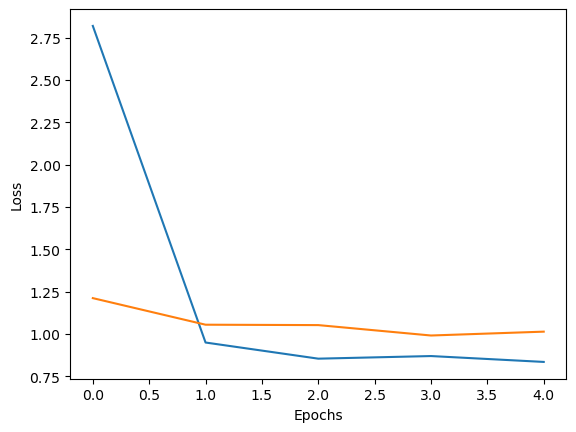

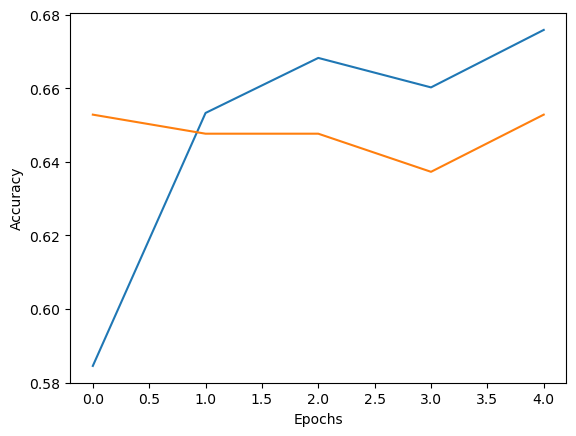

In [96]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001) #Modify learning rate if needed
cls_1_seq.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f_score, 'AUC'])
callbacks = [k.callbacks.EarlyStopping(patience=10)]
epochs1 = 5
batch_size = 16
steps_per_epoch = len(train_data)//4

history1 = cls_1_seq.fit(train_data, epochs=epochs1, steps_per_epoch=steps_per_epoch, class_weight=weights, batch_size=16, validation_data=val_data, verbose=1, callbacks=callbacks)

print_metrics(history1, epochs1)


# accuracy_from_val(classification_1, val_x, val_y)



In [97]:
cls_1_seq.save("classification_1_seq.keras")

In [47]:
cls_1_sq = k.models.load_model("classification_1_seq.keras", custom_objects={"f_score": f_score})

NameError: name 'cls_2_seq' is not defined

In [32]:
cls_2_seq = get_classification_sequential((224,224,3), 1, "classification_1_seq.keras")

ValueError: Exception encountered when calling layer "dense_8" (type Dense).

Dimensions must be equal, but are 7 and 9216 for '{{node dense_8/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](Placeholder, dense_8/MatMul/ReadVariableOp)' with input shapes: [?,7], [9216,256].

Call arguments received by layer "dense_8" (type Dense):
  • inputs=tf.Tensor(shape=(None, 7), dtype=float32)

In [ ]:
cls_2_seq.summary()

In [74]:
batch_size2 = 8
stage_2_input_shape = (224,224)

train_data2 = cls_datagen.flow_from_dataframe(df_train, directory=train_x, x_col="img_id", y_col="dx", target_size=stage_2_input_shape, color_mode='rgb', class_mode='categorical', batch_size=batch_size2, shuffle=True)
val_data2 = cls_datagen.flow_from_dataframe(df_val_meta, directory=val_x, x_col="img_id", y_col="dx", target_size=stage_2_input_shape, color_mode='rgb', class_mode='categorical', batch_size=batch_size2, shuffle=True)

Found 10015 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.


In [76]:
l_rate_2 = 0.001
epochs2 = 4
steps_per_epoch2 = len(train_data2)//4

optimizer2 = tf.keras.optimizers.SGD(learning_rate=l_rate_2)
cls_1_sq_stage2.compile(optimizer=optimizer2, loss="categorical_crossentropy", metrics=["accuracy", f_score, 'AUC'])
callbacks = []#k.callbacks.EarlyStopping(patience=5)

history2 = cls_1_sq_stage2.fit(train_data2, epochs=epochs2, steps_per_epoch=steps_per_epoch2, class_weight=weights, batch_size=len(train_data), validation_data=val_data2, verbose=1, callbacks=callbacks)
cls_1_sq_stage2.save("classification_2.keras")

Epoch 1/4


2024-02-06 22:17:53.599945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 51s 97ms/step - loss: 2.4923 - accuracy: 0.3004 - f_score: 0.4086 - auc: 0.6383 - val_loss: 3.8284 - val_accuracy: 0.3575 - val_f_score: nan - val_auc: 0.6712
Epoch 2/4
313/313 [==============================] - 28s 88ms/step - loss: 2.1567 - accuracy: 0.3526 - f_score: 0.4460 - auc: 0.6823 - val_loss: 4.1598 - val_accuracy: 0.2798 - val_f_score: nan - val_auc: 0.5885
Epoch 3/4
313/313 [==============================] - 27s 87ms/step - loss: 1.8974 - accuracy: 0.3970 - f_score: 0.4895 - auc: 0.7230 - val_loss: 1.9215 - val_accuracy: 0.5337 - val_f_score: 0.6076 - val_auc: 0.8022
Epoch 4/4
313/313 [==============================] - 27s 87ms/step - loss: 1.7452 - accuracy: 0.4313 - f_score: 0.5207 - auc: 0.7523 - val_loss: 2.4406 - val_accuracy: 0.4767 - val_f_score: 0.5363 - val_auc: 0.7691


In [22]:
#Classification Stage 3
classification_3 = get_classification("classification_2.keras", (448,448,3), "classification_3")
classification_3.summary()

Model: "classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 temp (Functional)           (None, 7)                 7763829   
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
Total params: 7763885 (29.62 MB)
Trainable params: 40563 (158.45 KB)
Non-trainable params: 7723322 (29.46 MB)
_________________________________________________________________


In [24]:
batch_size3 = 8
stage_3_input_shape = (448,448)

train_data2 = cls_datagen.flow_from_dataframe(df_train, directory=train_x, x_col="img_id", y_col="dx", target_size=stage_3_input_shape, color_mode='rgb', class_mode='categorical', batch_size=batch_size2, shuffle=True)
val_data2 = cls_datagen.flow_from_dataframe(df_val_meta, directory=val_x, x_col="img_id", y_col="dx", target_size=stage_3_input_shape, color_mode='rgb', class_mode='categorical', batch_size=batch_size2, shuffle=True)

Found 10015 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.


If you ony have the .keras file and haven't trained the model, run this to load your .keras file.

In [8]:
classification_3 = k.models.load_model("classification_3.keras", custom_objects={"f_score": f_score})

2024-02-06 01:16:48.938130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 01:16:49.126632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 01:16:49.126692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 01:16:49.128312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 01:16:49.128358: I external/local_xla/xla/stream_executor

Evaluation and Testing


image name = ISIC_0034536
1/1 [==============================] - 0s 27ms/step
True Label: 
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
12  ISIC_0034536  0.0  0.0  0.0    1.0  0.0  0.0   0.0

Predicted Scores -> 
[[0.02974907 0.00254295 0.0478618  0.12336263 0.00266426 0.7721632
  0.02165609]]


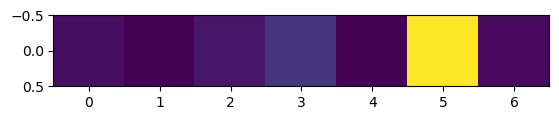

This image ISIC_0034536 is predicted to be DF with a 77.22 percent confidence.


In [65]:
class_names=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
labels_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

target_size = (500,500)
pred_folder = "test/ISIC2018_Task3_Test_Input"
#pred_image_name = "ISIC_00345" + str(np.random.randint(10, 99))
pred_label_df = pd.read_csv(labels_path)
picked_df = pred_label_df[pred_label_df.image.str.startswith("ISIC_00345")].sample(1)
pred_image_name = picked_df["image"].iloc[0]

pred_label_true = pred_label_df.loc[pred_label_df['image']==pred_image_name]

# test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image_name) + ".jpg"))
# pred_image = cv2.resize(test_image, target_size)
#from PIL import Image
print(f"image name = {pred_image_name}")
image_pillow = cv2.imread(os.path.join(pred_folder, pred_image_name) + ".jpg")
pred_image = cv2.resize(image_pillow, target_size)

img_array = tf.keras.utils.img_to_array(pred_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

score = cls_1_sq.predict(img_array)
label_name = class_names[np.argmax(score)]
confidence_percent = 100 * np.max(score)

#print(f"True Label: {pred_label_true}")

print(f"True Label: ")
print(f"{pred_label_true}\n")

print(f"Predicted Scores -> ")
print(score)
plt.imshow(score, interpolation="nearest")
plt.show()

print("This image {} is predicted to be {} with a {:.2f} percent confidence.".format(pred_image_name, label_name, confidence_percent))

In [31]:
# For loading classification labels and images.
# Standard Function, random sampling
def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

# Equal Sampling
def load_images_and_labels_equal(images_path, labels_path, batch_size, num_classes, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    samples_per_class = []
    class_indexes = []
    labels = pd.read_csv(labels_path)
    class_names = np.array(labels.columns[1:])
    images = os.listdir(images_path)
    for i in range(num_classes):
        samples_per_class.append(batch_size//num_classes)
    for i in range(batch_size%num_classes):
        samples_per_class[i] += 1
    instances_per_class = labels.sum(axis=0, numeric_only=True)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path} with equal sampling")
    for i in range(num_classes):
        #get all row indexes with 1 in ith row
        class_indexes = []
        p = 0
        for x in labels.iloc:
            if x[i+1] == 1:
                class_indexes.append(p)
            p+=1
        print(f"samples for {i} class: {samples_per_class[i]}, class_indexes len: {len(class_indexes)}")
        for x in range(samples_per_class[i]):
            random_index = np.random.randint(0, instances_per_class[i])
            ind = class_indexes[random_index]
            img = cv2.imread(os.path.join(images_path, images[ind]))
            row = labels.iloc[ind, 1:]
            if img is not None and row is not None:
                if not (samples_per_class[i] >= len(class_indexes)-1):
                    class_indexes.pop(random_index)
                    instances_per_class[i] -= 1
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape), dtype="uint8"))
                #assuming 1 column for image id
                #ds_labels.append(row.values) #for array labels
                ds_labels.append(class_names[np.where(row.values == 1)[0][0]]) #for string labels - make sure to remove .astype for labels
                #ds_labels.append(np.where(row.values == 1)[0][0]) #for integer labels
        print("1 class loaded")
        print(f"len ds_images: {len(ds_images)}")
        print(f"len ds_labels: {len(ds_labels)}")
    return np.array(ds_images).astype(np.uint8), pd.get_dummies(ds_labels).to_numpy()#k.utils.to_categorical(ds_labels, num_classes=num_classes)

loading images from test/ISIC2018_Task3_Test_Input and labels from test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv with equal sampling
samples for 0 class: 143, class_indexes len: 171
1 class loaded
len ds_images: 143
len ds_labels: 143
samples for 1 class: 143, class_indexes len: 909
1 class loaded
len ds_images: 286
len ds_labels: 286
samples for 2 class: 143, class_indexes len: 93
1 class loaded
len ds_images: 429
len ds_labels: 429
samples for 3 class: 143, class_indexes len: 43
1 class loaded
len ds_images: 572
len ds_labels: 572
samples for 4 class: 143, class_indexes len: 217
1 class loaded
len ds_images: 715
len ds_labels: 715
samples for 5 class: 143, class_indexes len: 44
1 class loaded
len ds_images: 858
len ds_labels: 858
samples for 6 class: 142, class_indexes len: 35
1 class loaded
len ds_images: 1000
len ds_labels: 1000


2024-02-06 22:10:19.831147: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602112000 exceeds 10% of free system memory.


32/32 [==============================] - 2s 30ms/step


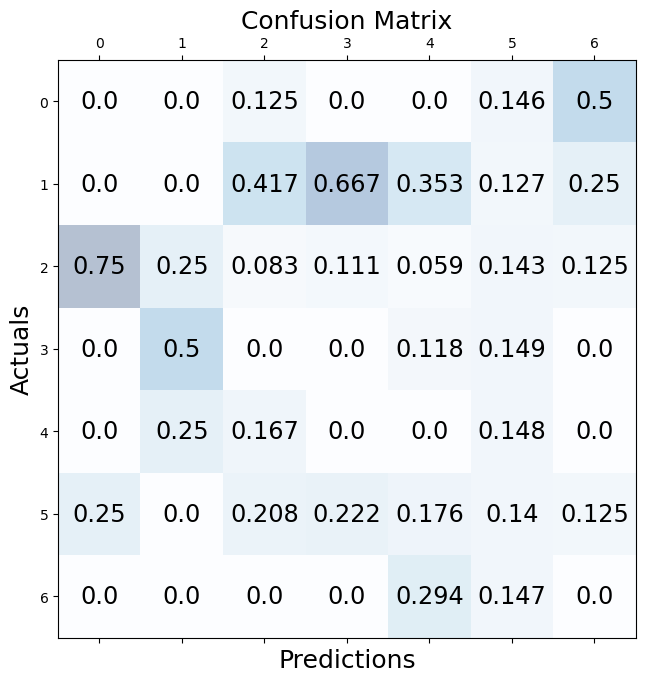

In [66]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

x_test_path = "test/ISIC2018_Task3_Test_Input"
y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
#len(pd.read_csv(y_test_path))
x_test, y_test = load_images_and_labels_equal(x_test_path, y_test_path, 1000, 7, (448,448), True) #outdated load function

y_prediction = cls_1_sq.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=np.round(result[i, j], 3), va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Converting to .tflite

In [18]:
def convert_to_tflite(model, name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(str(name), 'wb') as f:
      f.write(tflite_model)

In [19]:
classification_3.save("saved_model/task3_final")


INFO:tensorflow:Assets written to: saved_model/task3_final/assets


INFO:tensorflow:Assets written to: saved_model/task3_final/assets


In [20]:
!zip -r saved_model.zip /content/saved_model

	zip warning: name not matched: /content/saved_model

zip error: Nothing to do! (try: zip -r saved_model.zip . -i /content/saved_model)


In [4]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/task3_final") # path to the SavedModel directory
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2024-02-06 02:17:22.027072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-06 02:17:22.027116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-06 02:17:22.027249: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/task3_final
2024-02-06 02:17:22.083187: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-06 02:17:22.083217: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model/task3_final
2024-02-06 02:17:22.236973: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-06 02:17:22.996444: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: saved_model/task3_final
2024-02-06 02:17:23.296560: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: succ